In [1]:
# Original author: Jimena Gonzalez

In [2]:
script = False
cluster = False

# general
import numpy as np
import pandas as pd
from memory_profiler import memory_usage
import random
import os
import gc

# images & plotting
from astropy.io import fits
from astropy.visualization import make_lupton_rgb
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker

# pytorch
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import segmentation_models_pytorch as smp
from sklearn.model_selection import train_test_split

# albumentations transformations
import albumentations as A
from albumentations.pytorch import ToTensorV2

# loading bar
if(script):
    from tqdm import tqdm
else: 
    from tqdm.notebook import tqdm

plt.style.use('dark_background')

In [3]:
def seed_everything(seed):
    """
    Seeds basic parameters for reproductibility of results
    Arguments:
        seed {int} -- Number of the seed
    """
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [4]:
# Transformations
augs = A.Compose([
    A.OneOf([ A.ElasticTransform(alpha = 45*0.03, sigma = 45*0.39, alpha_affine =45*0.13)
#              A.GridDistortion(),
#              A.OpticalDistortion(distort_limit=2, shift_limit=0.5)
            ], p=1.)])

    
resize_transform = A.Compose([A.Resize(96, 96), ToTensorV2()])

In [5]:
class ImageDataset(Dataset):
    """Dataset of Images, Data and Labels"""

    def __init__(self, images, data, labels, mode=None, transform=None, resize=None):
        """
        Create a PyTorch dataset from as array of images and labels
        """
        super().__init__()
        self.images = images
        self.data = data
        self.labels = labels
        self.mode = mode
        self.transform = transform
        self.resize = resize

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        img = self.images[idx]  # get image
        image = self.normalize(img)
        label = self.labels[idx]  # get label
        data_point = self.data.iloc[idx].to_dict()  # get data

        # reshape
        image = image.transpose(1, 2, 0)

        # transform
        if self.transform is not None:
            image = image.astype(np.float32)
            transformed = self.transform(image=image, mask=label)
            image = transformed['image']
            label = transformed['mask']

        # resizing transformation
        resized = self.resize(image=image, mask=label)
        image = resized['image']
        label = resized['mask']
        sample = {'image': image, 'label': label,
                  'img': img, 'data': data_point}

        return sample

    def normalize(self, image):
        """
        normalizes 3-channel np array between 0 and 1
        """
        normed = np.empty((3, 45, 45))
        MIN = np.min(image)
        MAX = np.max(image)
        for band in range(3):
            flat = image[band].flatten(order='C')
            for i in range(len(flat)):
                flat[i] = (flat[i]-MIN)/(MAX-MIN)

            normed[band] = np.reshape(flat, (45, 45), order='C')

        return normed



In [8]:
seed_everything(9)

if(cluster):
    path = '/home/gcartwright/Segmentation/Image_Segmentation/' # OSG home
else:
    path = '/Users/gilliancartwright/Desktop/Research/Segmentation/Image-Segmentation/' # local

npos = 20  # TESTING

num_workers = 0
num_epochs = 6  # TESTING

# get data
hdu_list = fits.open(path + 'labeled_file.fits')
idx = random.sample(range(20), npos)

images = hdu_list[1].data[idx,:] 
images = images.astype(np.float32)

labels = hdu_list[5].data[idx,:] 
labels = labels.astype(np.float32)

data = pd.DataFrame(hdu_list[7].data[:][idx])
data = data.drop('TILENAME', axis=1)
hdu_list.close()

print(images.shape, labels.shape)

(20, 3, 45, 45) (20, 45, 45)


In [9]:
def make_train_test_datasets(images, data, labels, test_size, transform=None, resize=resize_transform):
    """
    Make training and testing datasets

    Args:
    * images: 4D array of all the images
    * data: pandas data frame from fits file
    * labels: 3D array of all the labels for each image
    * test_size: the fraction of the images to use as the test dataset
    * transform: albumentations transformations to apply to training dataset
    * resize: albumentations transform to resize (h, w) from (45, 45) to (96, 96)

    Returns
    * train_dataset: An instance of the ImageDataset Class for training
    * test_dataset: An instance of the ImageDataset Class for testing
    """

    # Shuffle and split data
    train_images, test_images, train_data, test_data, train_labels, test_labels = train_test_split(
        images, data, labels, test_size=test_size, random_state=6)
    
    # Create PyTorch Datasets
    return (ImageDataset(train_images, train_data, train_labels, transform=augs, resize=resize_transform),
            ImageDataset(test_images, test_data, test_labels, transform=None, resize=resize_transform))

In [10]:
train_dataset, other_dataset = make_train_test_datasets(images, data, labels, test_size=0.2,
                                                        transform=augs, resize=resize_transform)

valid_dataset, test_dataset = make_train_test_datasets(other_dataset.images, other_dataset.data,
                                                       other_dataset.labels, test_size=0.5,
                                                       transform=None, resize=resize_transform)
print('Len train dataset: {}, len test dataset: {}'.format(len(train_dataset), len(test_dataset)))

Len train dataset: 16, len test dataset: 2


In [11]:
def show_training_set(train_dataset, idx):
    loc = plticker.MultipleLocator(base=3.75)
    fig, ax = plt.subplots(figsize=(15, 4), ncols=3)
    
    sample = train_dataset[idx]
    orig_img, train_img, label_img = sample['img'], sample['image'], sample['label']
#     print(orig_img.shape, train_img.shape, label_img.shape)

    orig_rgb = make_lupton_rgb(orig_img[2],
                               orig_img[1],
                               orig_img[0], Q=11., stretch=40.)
    ax[0].set_title('Original Image')
    ax[0].xaxis.set_ticklabels([])
    ax[0].yaxis.set_ticklabels([])
    ax[0].imshow(orig_rgb, aspect='equal')

    new_rgb = make_lupton_rgb(train_img[2],
                              train_img[1],
                              train_img[0], stretch=.5, Q=4.)
    ax[1].set_title('Transformed Image')
    ax[1].xaxis.set_ticklabels([])
    ax[1].yaxis.set_ticklabels([])
    ax[1].imshow(new_rgb, aspect='equal')

    ax[2].set_title('Training Label')
    ax[2].xaxis.set_ticklabels([])
    ax[2].yaxis.set_ticklabels([])
    ax[2].imshow(label_img, aspect='equal')

    plt.show()
    plt.close()

In [12]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=5,
                                           num_workers=num_workers, shuffle=True)
valid_loader = torch.utils.data.DataLoader(dataset=valid_dataset, batch_size=5,
                                           num_workers=num_workers, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=1,
                                          num_workers=num_workers, shuffle=True)
torch.save(test_loader, 'test_loader.pth')

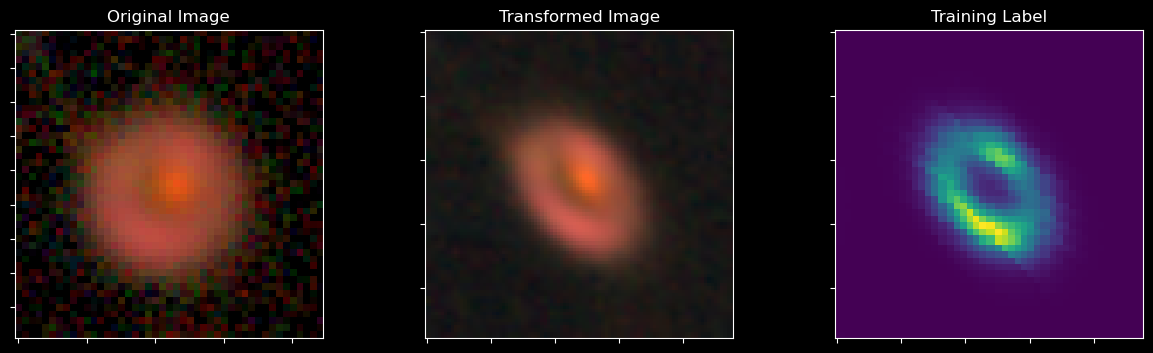

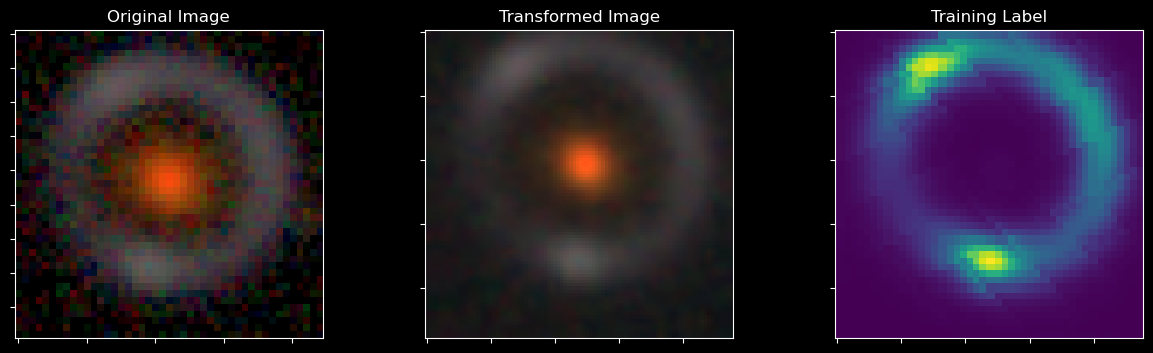

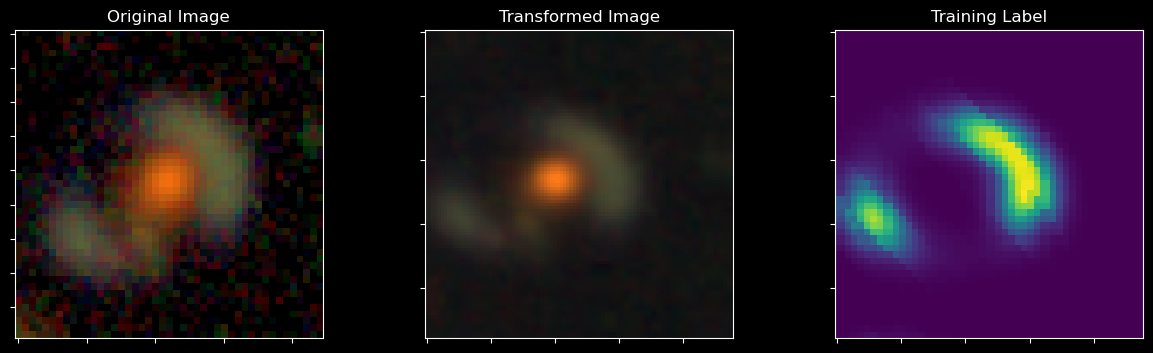

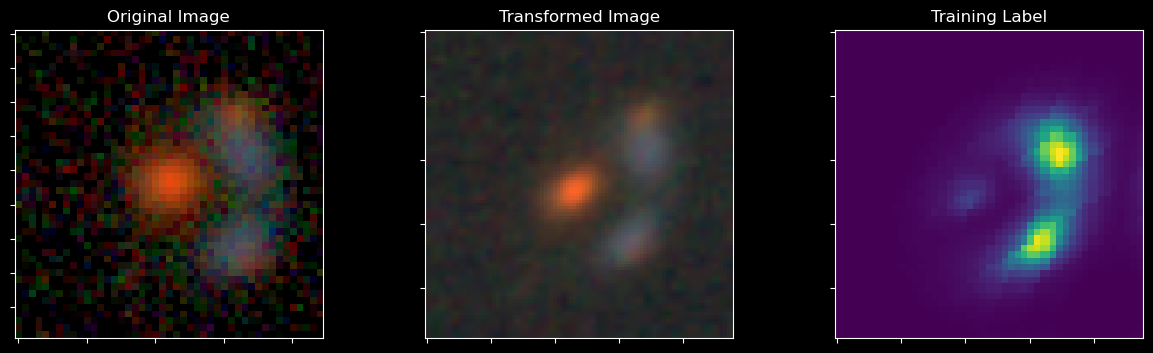

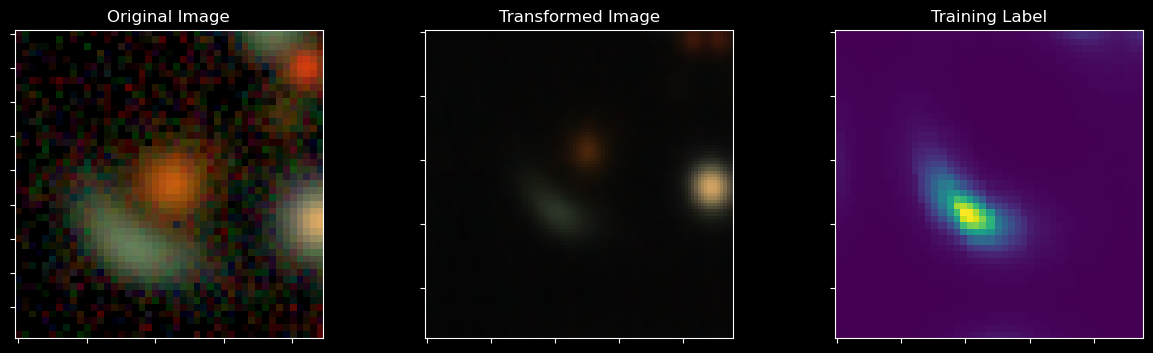

In [13]:
for idx in range(5):
    show_training_set(train_dataset, idx)

In [25]:
class ViTBase16(nn.Module):

    def __init__(self, n_classes, pretrained=False): 
        super(ViTBase16, self).__init__()
        self.model = smp.Unet(encoder_name="resnet50", encoder_weights="imagenet",
                              in_channels=3, classes=1)

        if(not cluster):
            self.model = smp.Unet(encoder_name="resnet50", encoder_weights="imagenet",
                                  in_channels=3, classes=1)
            torch.save(self.model.state_dict(), 'initial_model.pt')

        else:
            self.model = smp.Unet(encoder_name="resnet50", in_channels=3, classes=1)
            self.model.load_state_dict(torch.load('initial_model.pt'))


    def forward(self, x):
        x = self.model(x)
        return x


    def pseudo_accuracy(self, output, target):
        output = torch.sigmoid(output)
        print(output.size())
        print(target.size())
        num = target.size(0)
        m1 = output.view(num, -1)  # Flatten
        m2 = target.view(num, -1)  # Flatten
        print(m1.size())
        print(m2.size())
        intersection = (m1 * m2).sum()  #(dim=1)
        print(intersection)
        return(2. * intersection + 1.) / (m1.sum() + m2.sum() + 1.)


    def train_one_epoch(self, train_loader, criterion, optimizer, device):
        # keep track of training loss
        epoch_loss = 0.0
        epoch_accuracy = 0.0

        ###################
        # train the model #
        ###################

        self.model.train()

        for i, sample in enumerate(tqdm(train_loader)):
            data, target, sample_img, sample_data = sample['image'], sample['label'], sample['img'], sample['data']
            target = target.unsqueeze(1)

            # move tensors to GPU if CUDA is available
            if device.type == "cuda":
                data, target = data.cuda(), target.cuda()

            # clear the gradients of all optimized variables
            optimizer.zero_grad()

            # forward pass: compute predicted outputs by passing inputs to the model
            output = self.forward(data)

            # calculate the batch loss
            loss = criterion(output, target)

            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()

            # Calculate Accuracy
            accuracy = self.pseudo_accuracy(output, target)

            # update training loss and accuracy
            epoch_loss += loss
            epoch_accuracy += accuracy

            optimizer.step()

        return epoch_loss / len(train_loader.dataset), epoch_accuracy / len(train_loader)

    def validate_one_epoch(self, valid_loader, criterion, device):
        # keep track of validation loss
        valid_loss = 0.0
        valid_accuracy = 0.0

        ######################
        # validate the model #
        ######################
        self.model.eval()
        for i, sample in enumerate(tqdm(valid_loader)):
            data, target, sample_img, sample_data = sample['image'], sample['label'], sample['img'], sample['data']

            target = target.unsqueeze(1)

            # move tensors to GPU if CUDA is available
            if device.type == "cuda":
                data, target = data.cuda(), target.cuda()

            with torch.no_grad():
                # forward pass: compute predicted outputs by passing inputs to the model
                output = self.model(data)

                # calculate the batch loss
                loss = criterion(output, target)

                # Calculate Accuracy
                accuracy = self.pseudo_accuracy(output, target)

                # update average validation loss and accuracy
                valid_loss += loss
                valid_accuracy += accuracy

        return valid_loss / len(valid_loader.dataset), valid_accuracy / len(valid_loader)


In [26]:
model = ViTBase16(n_classes=9, pretrained=True)

criterion = nn.BCEWithLogitsLoss()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model.to(device)

learning_rate = 0.0001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


cpu


In [27]:
def fit_tpu(model, name_model, epochs, device, criterion, optimizer, train_loader, valid_loader=None):
    best_val_acc = 0.0 # track of best accuracy

    # keeping track of losses as it happen
    train_losses = []
    valid_losses = []
    train_accs = []
    valid_accs = []

    for epoch in range(1, epochs + 1):
        gc.collect()
        
        print(f"{'=' * 100}")
        print(f"EPOCH {epoch} - TRAINING...")
        train_loss, train_acc = model.train_one_epoch(train_loader, criterion, optimizer, device)
        print(f"\n\t[TRAIN] EPOCH {epoch} - LOSS: {train_loss}, ACCURACY: {train_acc}\n")
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        gc.collect()

        # moves towards valid_loader
        print("start valid_loader")

        if valid_loader is not None:
            gc.collect()
            print(f"EPOCH {epoch} - VALIDATING...")
            valid_loss, valid_acc = model.validate_one_epoch(valid_loader, criterion, device)
            print(f"\t[VALID] LOSS: {valid_loss}, ACCURACY: {valid_acc}\n")
            valid_losses.append(valid_loss)
            valid_accs.append(valid_acc)
            gc.collect()

            if(valid_acc > best_val_acc):
                setattr(model, 'loss_train', train_losses)
                setattr(model, 'loss_valid', valid_losses)
                setattr(model, 'train_acc', train_accs)
                setattr(model, 'validation_acc', valid_accs)
                torch.save(model, name_model)
                best_val_acc = valid_acc

In [28]:
def plot_performance(cnn):
    loss_train = [x.item() for x in cnn.loss_train]
    loss_valid = [x.item() for x in cnn.loss_valid]
    train_acc = [x.item() for x in cnn.train_acc]
    valid_acc = [x.item() for x in cnn.validation_acc]
    
    x = np.linspace(1,len(cnn.loss_train),len(cnn.loss_train))
    fig, (ax1, ax2) = plt.subplots(figsize=(16, 7), ncols=2)
    
    ax1.set_title('Losses')
    ax1.set_xlabel('Epoch')
    ax1.scatter(x, loss_train, color = 'skyblue', alpha = 0.8, label = 'Training loss')
    ax1.scatter(x, loss_valid, color = 'limegreen', alpha = 0.8,  label = 'Validation loss')
    ax1.legend()
    
    ax2.set_title('Performance. Max: {:.4f}%'.format(100*cnn.validation_acc[-1].item()))
    ax2.set_xlabel('Epoch')
    ax2.scatter(x, train_acc, color = 'skyblue', alpha = 0.8,  label = 'Training Accuracy')
    ax2.scatter(x, valid_acc, color = 'limegreen', alpha = 0.8,  label = 'Validation Accuracy')
    ax2.legend()
    
    if(script):
        plt.savefig('Performance.png', bbox_inches='tight')
        plt.close()
    else: 
        plt.show(block=True)
    

In [29]:
name_model = 'model.pt'
mem_usage = memory_usage((fit_tpu, (model, name_model, num_epochs,
                                    device, criterion, optimizer, train_loader, valid_loader)))
# fit_tpu(model, name_model, num_epochs, device, criterion, optimizer, train_loader, valid_loader)

EPOCH 1 - TRAINING...


  0%|          | 0/4 [00:00<?, ?it/s]

torch.Size([5, 1, 96, 96])
torch.Size([5, 1, 96, 96])
torch.Size([5, 9216])
torch.Size([5, 9216])
tensor(2537.1460, grad_fn=<SumBackward0>)
torch.Size([5, 1, 96, 96])
torch.Size([5, 1, 96, 96])
torch.Size([5, 9216])
torch.Size([5, 9216])
tensor(2751.1741, grad_fn=<SumBackward0>)


Process MemTimer-3:
Traceback (most recent call last):
  File "/Users/gilliancartwright/miniconda3/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/Users/gilliancartwright/miniconda3/lib/python3.9/site-packages/memory_profiler.py", line 260, in run
    stop = self.pipe.poll(self.interval)
  File "/Users/gilliancartwright/miniconda3/lib/python3.9/multiprocessing/connection.py", line 262, in poll
    return self._poll(timeout)
  File "/Users/gilliancartwright/miniconda3/lib/python3.9/multiprocessing/connection.py", line 429, in _poll
    r = wait([self], timeout)
  File "/Users/gilliancartwright/miniconda3/lib/python3.9/multiprocessing/connection.py", line 936, in wait
    ready = selector.select(timeout)
  File "/Users/gilliancartwright/miniconda3/lib/python3.9/selectors.py", line 416, in select
    fd_event_list = self._selector.poll(timeout)
KeyboardInterrupt


KeyboardInterrupt: 

In [20]:
# print('Maximum memory usage: %s' % max(mem_usage))ws

In [21]:
name = 'model.pt'#'model.pt'#'other.pt' 
model = torch.load(name, map_location=torch.device('cpu'))
print('Maximum validation accuracy: {:.2f}%'.format(100*model.validation_acc[-1].item()))

test_loader = torch.load('test_loader.pth')

In [22]:
plot_performance(model)

In [23]:
def make_graphs(name, image, label, predicted_label):    
    loc = plticker.MultipleLocator(base=3.75)
    fig, (ax1, ax2, ax3) = plt.subplots(figsize=(15, 4), ncols=3)

    rgb = make_lupton_rgb(image[2], image[1], image[0], Q=11., stretch=40.)
    ax1.set_title('Image')
    ax1.xaxis.set_ticklabels([])
    ax1.yaxis.set_ticklabels([])
    original = ax1.imshow(rgb, aspect='equal')
    
    img2 = ax2.imshow(label)
    ax2.set_title('True Label')
    plt.colorbar(img2, ax=ax2)
    
    img3 = ax3.imshow(predicted_label[0][0].detach().numpy())
    ax3.set_title('Predicted')
    plt.colorbar(img3, ax=ax3)
   
    #plt.savefig(sub_path + 'Data/Sim_complete/Image' + name + '.png', bbox_inches='tight')
    plt.show()

In [24]:
def testing_analysis(accu_lim, test_loader):
    model.double()
    right_pos_img, wrong_pos_img = np.zeros((1,3,45,45)), np.zeros((1,3,45,45))
    right_neg_img, wrong_neg_img = np.zeros((1,3,45,45)), np.zeros((1,3,45,45))

    for i_batch, sample in enumerate(tqdm(test_loader)):
        if(i_batch == 100): break
        sample_image, sample_label, sample_img, sample_data = sample['image'], sample['label'], sample['img'], sample['data']
        
        
        if device.type == "cuda":
            sample_image, sample_label = sample_image.cuda(), sample_label.cuda()
        
        
        output = model(sample_image)  # sample_image.double()
        output = torch.sigmoid(output)
        if(not cluster):
            sample_img = sample_img[0]
            print(sample_label[0].shape)
            make_graphs('name', sample_img, sample_label[0], output)


In [25]:
testing_analysis(0.5, test_loader)


In [26]:
plt.close('all')